In [129]:
using DifferentialEquations
using BenchmarkTools
using Plots
using BeamPropagation
using PhysicalConstants

In [328]:
const μ = PhysicalConstants.CODATA2018.BohrMagneton.val
;

In [1274]:
const max_Bfield = @with_unit 1.5 "T"
const mass = @with_unit 190 "u"
const t_end = @with_unit 30 "ms" 
const kB = PhysicalConstants.CODATA2018.BoltzmannConstant.val
;

In [1275]:
function B_timedep(t)
    val = 0.1
    if t < t_end
        val += (t_end - t) / t_end
    end
    return val
end

B_timedep (generic function with 1 method)

In [1276]:
function compute_force(x, y, z, t)
    
    length = sqrt(x^2 + y^2 + z^2)
    E = μ * max_Bfield * B_timedep(t)
    
    return (-E * x / length, -E * y / length, -E * z / length)
end
;

In [1277]:
@btime compute_force(1.0, 1.0, 1.0, 1.0)
;

  1.100 ns (0 allocations: 0 bytes)


In [1278]:
function f(du, u, p, t)
    
    F = compute_force(u[1], u[2], u[3], t)
    
    du[4] = F[1] / mass
    du[5] = F[2] / mass
    du[6] = F[3] / mass
    du[1] = u[4]
    du[2] = u[5]
    du[3] = u[6]
   
    return nothing
end
;

In [1279]:
u0 = zeros(Float64, 6)
u0[1] = 0.003
u0[2] = 0.001
u0[4] = 0.6
u0[5] = 0.6
tspan = (0.0, 2*t_end)
tstops = tspan[1]:(tspan[2] / 100):tspan[2]

prob = ODEProblem(f, u0, tspan)
@time sol = solve(prob, DP5(), reltol=1e-10, abstol=1e-10, tstops=tstops)
# @time sol = solve(prob, Feagin12(), reltol=1e-10, abstol=1e-10, tstops=tstops)
;

  1.236638 seconds (1.65 M allocations: 81.863 MiB, 99.99% compilation time)


In [1280]:
xs = [u[1] for u in sol.u]
ys = [u[2] for u in sol.u]
vxs = [u[4] for u in sol.u]
vys = [u[5] for u in sol.u]
;

In [1281]:
function compute_energy(x, y, z, vx, vy, vz, t)
    
    v_squared = vx^2 + vy^2 + vz^2
    length = sqrt(x^2 + y^2 + z^2)
    
    KE = (1/2) * mass * v_squared
    PE = μ * max_Bfield * length * B_timedep(t)
   
    return KE + PE
end
;

In [1282]:
rs = [sqrt(u[1]^2 + u[2]^2 + u[3]^2) for u in sol.u]
vs = [sqrt(u[4]^2 + u[5]^2 + u[6]^2) for u in sol.u]
KEs = (1/2) * mass .* vs.^2
PEs = (μ * max_Bfield .* rs) .* B_timedep.(sol.t)
;

In [1283]:
Es = KEs .+ PEs
Ts = Es ./ kB
;

In [1284]:
# plot(sol.t, KEs, ylims=(0, maximum(Es)))
# plot!(sol.t, PEs, ylims=(0, maximum(Es)))

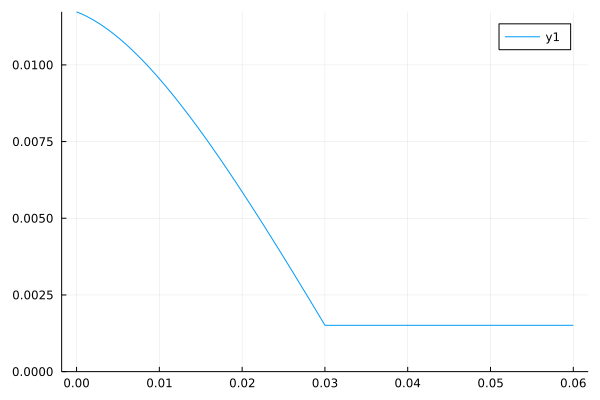

In [1285]:
plot(sol.t, Ts, ylims=(0, maximum(Ts)))

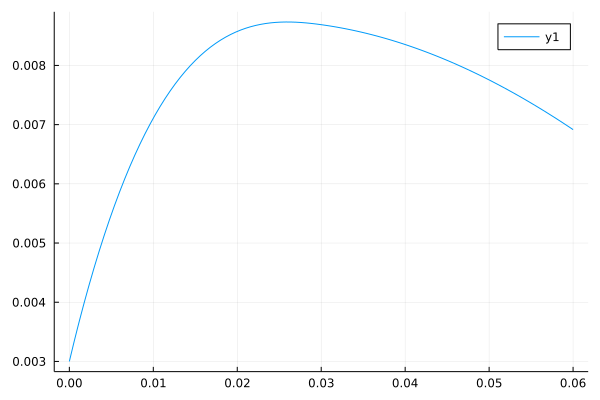

In [1286]:
plot(sol.t, xs)

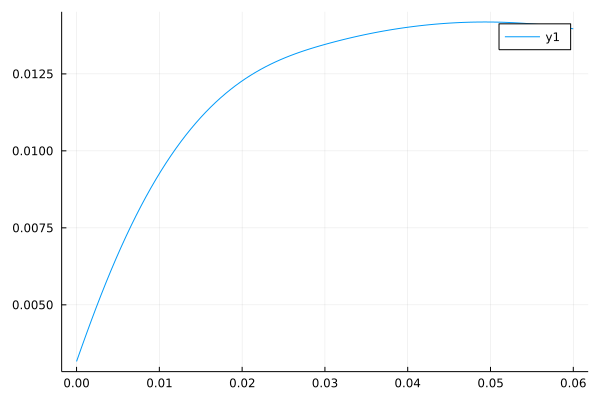

In [1287]:
plot(sol.t, rs)

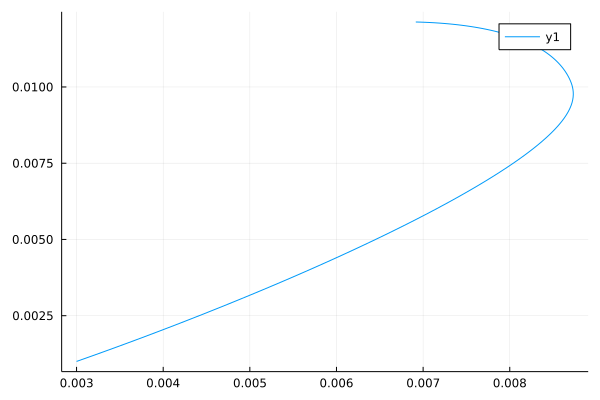

In [1288]:
plot(xs, ys)

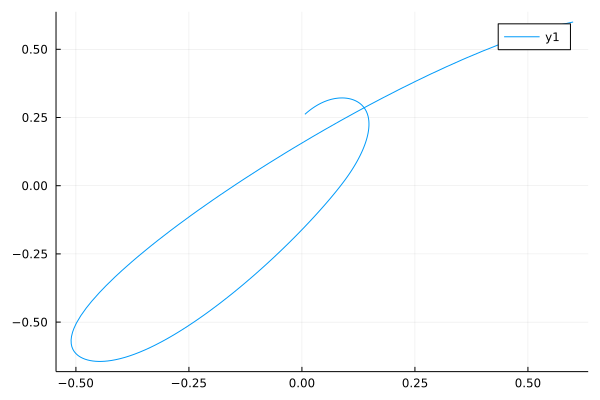

In [1273]:
plot(vxs, vys)